In [ ]:

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())

True
(6, 0)


In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/IDA.zip" /content/

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/loadbm.py" /content/

In [ ]:
%%capture
!unzip IDA.zip

In [ ]:
import numpy as np
import os
import ntpath
import platform
import matplotlib.pyplot as plt
from loadbm import create_df, create_tf_dataset, prepare_for_training


datapath = 'IDA/Separate lists with numbering/Machine learning splits'
img_path = 'IDA/Images/'

split = 1

train_fname = 'train'+str(split)+'.txt'
test_fname = 'test'+str(split)+'.txt'
val_fname = 'val'+str(split)+'.txt'

part_dat = False

df_train = create_df(os.path.join(datapath, train_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_test = create_df(os.path.join(datapath, test_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_val = create_df(os.path.join(datapath, val_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_val = shuffle(df_val)

df_train.head()

,path,label
119740,IDA/Images/Hydropsyche_pel81/1-Hydropsyche_pel...,13
119153,IDA/Images/Hydropsyche_pel59/0-Hydropsyche_pel...,13
139820,IDA/Images/Isoperla226/1-Isoperla226.1.2016-12...,16
309566,IDA/Images/Sphaerium113/0-Sphaerium113.1.2016-...,38
301584,IDA/Images/Simuliidae685/0-Simuliidae685.1.201...,37


Text(0.5, 1.0, 'pre-sampling')

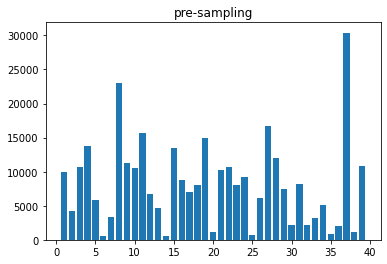

In [ ]:
h = np.histogram(df_train['label'],bins=39)[0]
plt.bar(range(1,40), h)
plt.title('pre-sampling')

In [ ]:
import pandas as pd
def undersample_df(df):
    
    h = np.histogram(df['label'],bins=39)[0]
    a = np.mean(h).astype(int)
    
    lst = []
    for i, group in df.groupby('label'):
        
        if a>len(group):
            lst.append(group)
        else:
            lst.append(group.sample(a, replace=False))
        
    return pd.concat(lst)

Duplicate samples: -92026.
 Percentage: -0.40119277533884673


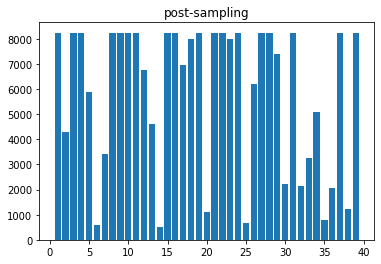

In [ ]:
df_train_new = undersample_df(df_train)

h_new = np.histogram(df_train_new['label'],bins=39)[0]
plt.bar(range(1,40), h_new)
plt.title('post-sampling')
dup_amount = len(df_train_new)-len(df_train)
print('Duplicate samples: {}.\n Percentage: {}'.format(dup_amount,
                                                       dup_amount/len(df_train_new)))
df_train = df_train_new.copy()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMSIZE = (224,224,3)
BATCH_SIZE = 32

train_ds = create_tf_dataset(df_train, imsize=IMSIZE, onehot=True)

val_ds = create_tf_dataset(df_val, imsize=IMSIZE, onehot=True)


train_ds = prepare_for_training(train_ds, 
                                shuffle_buffer_size=1000,
                                batch_size=BATCH_SIZE)

val_ds = prepare_for_training(val_ds, 
                              shuffle_buffer_size=1000,
                              batch_size=BATCH_SIZE)



for image, label in train_ds.take(5):
    print(image.shape)
    print(label.shape)


(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


def get_pretrained(imsize=(224, 224, 3), classes=39):
        base_model = InceptionV3(input_shape = imsize, 
                                 weights='imagenet', 
                                 include_top=False)
        
        base_model.trainable = True
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

model = get_pretrained()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
import datetime

tr_steps = len(df_train)//BATCH_SIZE
val_steps = len(df_val)//BATCH_SIZE

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 10,
          validation_steps = val_steps)


Epoch 1/10
7168/7168 [==============================] - 1150s 160ms/step - loss: 0.4842 - accuracy: 0.8784 - val_loss: 12.9869 - val_accuracy: 0.0561
Epoch 2/10
7168/7168 [==============================] - 1142s 159ms/step - loss: 0.3340 - accuracy: 0.9026 - val_loss: 14.1547 - val_accuracy: 0.0553
Epoch 3/10
7168/7168 [==============================] - 1142s 159ms/step - loss: 0.2993 - accuracy: 0.9116 - val_loss: 14.2740 - val_accuracy: 0.0564
Epoch 4/10
7168/7168 [==============================] - 1142s 159ms/step - loss: 0.2616 - accuracy: 0.9204 - val_loss: 20.5262 - val_accuracy: 0.0581
Epoch 5/10
7168/7168 [==============================] - 1144s 160ms/step - loss: 0.2749 - accuracy: 0.9145 - val_loss: 37.7007 - val_accuracy: 0.0550
Epoch 6/10
7168/7168 [==============================] - 1143s 159ms/step - loss: 0.2604 - accuracy: 0.9177 - val_loss: 16.6634 - val_accuracy: 0.0573
Epoch 7/10
7168/7168 [==============================] - 1143s 159ms/step - loss: 0.2592 - accuracy: 

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001) #original 0.001

from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    return 0.0001 * tf.math.exp(0.1 * (-epoch))

lr_cb = LearningRateScheduler(scheduler)

model.compile(optimizer = adam, loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 5,
          validation_steps = val_steps,
          callbacks=[lr_cb])

In [ ]:
model.save('24-02-2020_cont_colab.h5')

In [ ]:
!cp '24-02-2020_cont_colab.h5' "/content/drive/My Drive/koulu_honmia/kandi19/"

Evaluation:

In [ ]:
test_ds = create_tf_dataset(df_test, imsize=IMSIZE, onehot=True)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/combine_insects.py" /content/

In [ ]:
preds = model.predict(test_ds, verbose=True)
yhat = np.argmax(preds,axis=1)+1
y_test = df_test['label']

acc = np.sum(yhat==y_test)/len(y_test)
print('Image accuracy: {:.4f}'.format(acc))

2897/2897 [==============================] - 144s 50ms/step
Image accuracy: 0.0354


In [ ]:
#%% Insect combine
from combine_insects import add_insect_class, add_yhat

df_test_preds = add_insect_class(df_test)

# adding predictions to dataframe for insect-wise prediction
df_test_preds = add_yhat(df_test_preds,yhat)

dfg = df_test_preds.groupby(['label','insect'],as_index=False)['pred'].agg(lambda x:x.value_counts().index[0])

acc_g = np.sum(dfg['pred']==dfg['label'])/len(dfg)
print('Aggregate accuracy: {:.4f}'.format(acc_g))

Aggregate accuracy: 0.0342


In [ ]:
np.save('37-xx-2020.npy', preds)

In [ ]:
!cp '37-xx-2020.npy' "/content/drive/My Drive/koulu_honmia/kandi19/"